# I. Introduction
  

Centers for Medicare and Medicaid Services (CMS) has provided a dataset “Physician and Other
Supplier PUF” with information on services and procedures provided under Medicare from 2012
to 2018. With almost 10 million rows and 26 features, a wealth of information and trends can be
extracted from the dataset. One class of useful information that can be drawn from this dataset is
the healthcare industry’s pattern of spending, where insights can be drawn to optimize healthcare
costs. Healthcare expenditure in the United States by far surpasses any other nation, as in 2018 it
amounted to 3.6 trillion dollars per year, accounting for 19.4\% of the GDP. Understanding patterns within expenditure, such as in which
types of segments of the healthcare industry the expenditure is concentrated in, would be beneficial
for Medicare and other public and private healthcare entities. 

Source of the Data: Center for Medicare and Medicaid Services (CMS)\
Link: https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Physician-and-Other-Supplier

## Goals

The emergency department is chaotic in nature and requires a lot of resources, and therefore is often expensive to manage. Therefore, understanding the pattern of expenditure in ED services is crucial for healthcare entities and systems to efficiently operate. The goal of this analysis is to generate insights about spending patterns by Emergency Departments via segmenting lines of services with similar characteristics into different groups by using K-means clustering.

Because the dataset contains many
different types of services, **I decided to focus on services provided occurring in the Emergency
Department (ED)**.

Through K-means clustering, I produced a dataset that grouped each line of services (by a given provider)
relevant to the Emergency Department into 11 different clusters. Each cluster is associated with a certain characteristic
and has information about Medicare’s expenditure patterns for the specific cluster. Healthcare
system managers can get a brief overview of whether the expenses are being allocated correctly,
and whether the services that tend to be more expensive and dealing with more severe cases are being covered
proportionately more by Medicare. 

## Dataset

**Each row of the dataset represents a specific line of service given by the specified
provider.**

The dataset has 26 features, including information of the provider such as name,
credentials, location, and field of practice. It also includes information about the type of service
provided, as well as the number of times that specific line of service has been provided, and its
average cost to Medicare and the beneficiaries.

Some notable features include the following:
- name, address/country, and identifier code for the performing provider 
- `nppes_entity_code`: Type of entity of the provider. 
    - `nppes_entitycode = I`: identifies providers registered as an individual (e.g. a doctor)
    - `nppes_entitycode = O`: identifies providers registered as an organization
- `nppes_credentials`: Credentials of the provider.
    - This field is blank when `nppes_entity_code` is `O`. 
- `provider_type`: The specialty of the field that the physician or professional (provider) is associated with
    - Because there were a lot of different provider types, I took a subset of five of the most common ones.
    - Emergency Medicine, Physician Assistant, Nurse Practitioner, Internal Medicine, Cardiology
- `hcpcs_code`: Represents the HCPCS code that identifies the `provider_description`
- `hcpcs_description`: Provides the type of the service provided
- `line_srvc_cnt`: Represents the number of services provided per provider (2012-2018)
- `average_Medicare_allowed_amt`: Represents the average of the sum of the following for each service provided 
    - Amount paid by Medicare 
    - Amount paid by beneficiaries (copays/deductibles)
    - Amount paid by third party
- `average_Medicare_payment_amt`: Average amount that Medicare paid (after deductible and coinsurance have been deducted for the service). 
- `average_Medicare_standardized_amt`: Standardized average amount that Medicare paid 
    - Adjusts for geographic differences in payment rates for individual services
    - Available starting on data collected from 2014 

I also added a new feature
- `average_perc_covered`: Percentage of the total bill paid by Medicare (standardized). 


# II. Data Cleaning/Preparation

### A. Importing packages/Data

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
pd.set_option('display.max_columns', None) #displaying all columns in the data
pd.set_option('display.max_rows', None) #displaying all rows
pd.options.display.max_colwidth = 1000

In [2]:
df = pd.read_csv('data/medicare.txt', delimiter="\t", low_memory=False)

View of the first five rows of the data

In [3]:
df = df.iloc[1:] #removing unnecessary first row
df.head(5)

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_mi,nppes_credentials,nppes_provider_gender,nppes_entity_code,nppes_provider_street1,nppes_provider_street2,nppes_provider_city,nppes_provider_zip,nppes_provider_state,nppes_provider_country,provider_type,medicare_participation_indicator,place_of_service,hcpcs_code,hcpcs_description,hcpcs_drug_indicator,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt
1,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,21502,MD,US,Internal Medicine,Y,F,99217,Hospital observation care on day of discharge,N,68.0,67.0,68.0,73.821029,381.308824,57.880294,58.212500
2,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,21502,MD,US,Internal Medicine,Y,F,99218,"Hospital observation care, typically 30 minutes",N,19.0,19.0,19.0,100.883158,476.947368,76.795263,77.469474
3,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,21502,MD,US,Internal Medicine,Y,F,99220,"Hospital observation care, typically 70 minutes",N,26.0,26.0,26.0,188.110769,1086.923077,147.479231,147.793462
4,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,21502,MD,US,Internal Medicine,Y,F,99221,"Initial hospital inpatient care, typically 30 minutes per day",N,24.0,24.0,24.0,102.240000,474.583333,80.155000,80.943333
5,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,21502,MD,US,Internal Medicine,Y,F,99222,"Initial hospital inpatient care, typically 50 minutes per day",N,17.0,17.0,17.0,138.045882,625.000000,108.225294,109.220000


### B. Choosing a Subset of the Data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9961865 entries, 1 to 9961865
Data columns (total 26 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   npi                               int64  
 1   nppes_provider_last_org_name      object 
 2   nppes_provider_first_name         object 
 3   nppes_provider_mi                 object 
 4   nppes_credentials                 object 
 5   nppes_provider_gender             object 
 6   nppes_entity_code                 object 
 7   nppes_provider_street1            object 
 8   nppes_provider_street2            object 
 9   nppes_provider_city               object 
 10  nppes_provider_zip                object 
 11  nppes_provider_state              object 
 12  nppes_provider_country            object 
 13  provider_type                     object 
 14  medicare_participation_indicator  object 
 15  place_of_service                  object 
 16  hcpcs_code                        ob

**There are 9,961,865 instances in the dataset. There are 8 numeric features and 17 categorical features.**

Below, I explored select interesting features to see how they're distributed in the dataset, and used this information to narrow down my dataset. 

In [5]:
features_cat = ['nppes_credentials', 
                'nppes_entity_code', 
                'nppes_provider_country', 
                'provider_type', 
                'medicare_participation_indicator', 
                'place_of_service', 
                'hcpcs_description', 
                'hcpcs_drug_indicator']
for f in features_cat:
    print(f.upper())
    print(df[f].value_counts().head(5))
    print("")

NPPES_CREDENTIALS
M.D.    3214869
MD      3199892
D.O.     361945
DO       251854
PA-C     206356
Name: nppes_credentials, dtype: int64

NPPES_ENTITY_CODE
I    9542267
O     419598
Name: nppes_entity_code, dtype: int64

NPPES_PROVIDER_COUNTRY
US    9959601
XX       1685
JP        114
CA         75
DE         70
Name: nppes_provider_country, dtype: int64

PROVIDER_TYPE
Diagnostic Radiology    1246653
Internal Medicine       1054533
Family Practice          952894
Nurse Practitioner       630826
Cardiology               431235
Name: provider_type, dtype: int64

MEDICARE_PARTICIPATION_INDICATOR
Y    9958654
N       3211
Name: medicare_participation_indicator, dtype: int64

PLACE_OF_SERVICE
O    6132242
F    3829623
Name: place_of_service, dtype: int64

HCPCS_DESCRIPTION
Established patient office or other outpatient visit, typically 15 minutes    464384
Established patient office or other outpatient, visit typically 25 minutes    443515
New patient office or other outpatient visit, typica

Vast majority of providers are from the USA, individuals, have `hcpcs_drug_indicator` as No, and participate in Medicare. Many providers are MDs or DOs. 

To see the most relevant `hcpcs_description` to the emergency department, I identified every `hcpcs_description` with the word "Emergency Department." This isn't an exhaustive list of services in the ED, but ensures that all of them occur within ED.

In [6]:
(df['hcpcs_description'].str.match('Emergency department'))
ed_service_types = df[df['hcpcs_description'].str.match('Emergency department')].groupby(['hcpcs_code','hcpcs_description']).size().reset_index(name="count")
top_ed_services = ed_service_types.sort_values(by="count", ascending = False).reset_index(drop=True)
top_ed_services 

,hcpcs_code,hcpcs_description,count
0,99284,"Emergency department visit, problem of high severity",62068
1,99285,"Emergency department visit, problem with significant threat to life or function",58698
2,99283,"Emergency department visit, moderately severe problem",56331
3,99282,"Emergency department visit, low to moderately severe problem",8028
4,99281,"Emergency department visit, self limited or minor problem",612


To conduct meaningful analysis about spending patterns in the Emergency Department, I needed to take a small subset of this dataset. I decided to narrow down my rows into the following criteria:
-	Provider must participate in Medicare
-	Provider must be based in the United States
-	Provider must be registered in NPPES as an individual (entity type code `I`)
-	The type of service (`hcpcs_description`) must be in one of five top categories
    - Emergency department visit, problem with significant threat to life or function (**HCPCS Code 99285**)
    - Emergency department visit, problem of high severity (**HCPCS Code 99284**)
    - Emergency department visit, moderately severe problem (**HCPCS Code 99283**)
    - Emergency department visit, low to moderately severe problem (**HCPCS Code 99282**)
    - Emergency department visit, self limited or minor problem (**HCPCS Code 99281**)

It's good to know that the dataset is almost entirely composed of the visits of top 3 severity levels: 
- **Life threatening Severity**
- **High Severity**
- **Moderate Severity**

Other two severity levels are relatively uncommon.

In [34]:
top_ed_hcpcs_codes = top_ed_services['hcpcs_code'].tolist() # storing emergency dept codes
df_ED = df[(df['medicare_participation_indicator'] == 'Y') &
        (df['nppes_provider_country'] == 'US') & 
        (df['nppes_entity_code'] == 'I') &
        (df['place_of_service'] == 'F') & # place of service of in a facility ("F"), not at an office setting ("O")
        (df['hcpcs_code'].isin(top_ed_hcpcs_codes))]

185692

**Note: I didn't require `provider_type` to be Emergency Medicine. Other providers like Internal Medicine or General Surgery can also provide services in the Emergency Department**

In [35]:
df_ED = df_ED.drop(['nppes_provider_last_org_name', 
           'nppes_provider_first_name', 
           'nppes_provider_mi',
           'nppes_provider_gender',
           'nppes_credentials',
           'nppes_provider_street1', 
           'nppes_provider_street2',
           'nppes_provider_city',
           'nppes_provider_state',
           'nppes_provider_zip', 
           'nppes_provider_country',
           'medicare_participation_indicator', # all rows will already be "Y"
           'nppes_entity_code', # all rows will already be 'I'
           'hcpcs_code',
           'bene_unique_cnt',
           'bene_day_srvc_cnt',
           'average_submitted_chrg_amt',
           'average_Medicare_payment_amt',
           'place_of_service', # all will be "F"
           'hcpcs_drug_indicator',
           'npi'
                   ], axis = 1)

I decided to further narrow down the dataset to lines of services that have `provider_type` within the five most common categories.

In [37]:
df_ED = df_ED[df_ED['provider_type'].isin(['Emergency Medicine',
                                     'Physician Assistant', 
                                     'Nurse Practitioner', 
                                     'Internal Medicine',
                                     'Cardiology'])]

I add a feature `average_perc_covered` that describes the percentage of cost covered by Medicare. 

In [38]:
df_ED['average_perc_covered'] = 100*df_ED['average_Medicare_standard_amt']/df_ED['average_Medicare_allowed_amt']
df_ED.head(5)

,provider_type,hcpcs_description,line_srvc_cnt,average_Medicare_allowed_amt,average_Medicare_standard_amt,average_perc_covered
241,Physician Assistant,"Emergency department visit, moderately severe problem",16.0,56.34,34.108750,60.540912
242,Physician Assistant,"Emergency department visit, problem of high severity",19.0,106.85,58.870000,55.095929
619,Emergency Medicine,"Emergency department visit, low to moderately severe problem",11.0,41.73,32.963636,78.992658
620,Emergency Medicine,"Emergency department visit, moderately severe problem",66.0,62.47,47.449091,75.955004
621,Emergency Medicine,"Emergency department visit, problem of high severity",90.0,118.57,90.604667,76.414495


### C. Removing Outliers/Visualizations

Clustering can be rather sensitive to outliers. After examining the data, I decided to remove any instances with `line_srvc_cnt` > 1000, and ensured `average_perc_covered` was equal or less than 100% to remove errors potentially caused by data entry mistakes or unusual circumstances. I then plotted a histogram for each numerical variable.

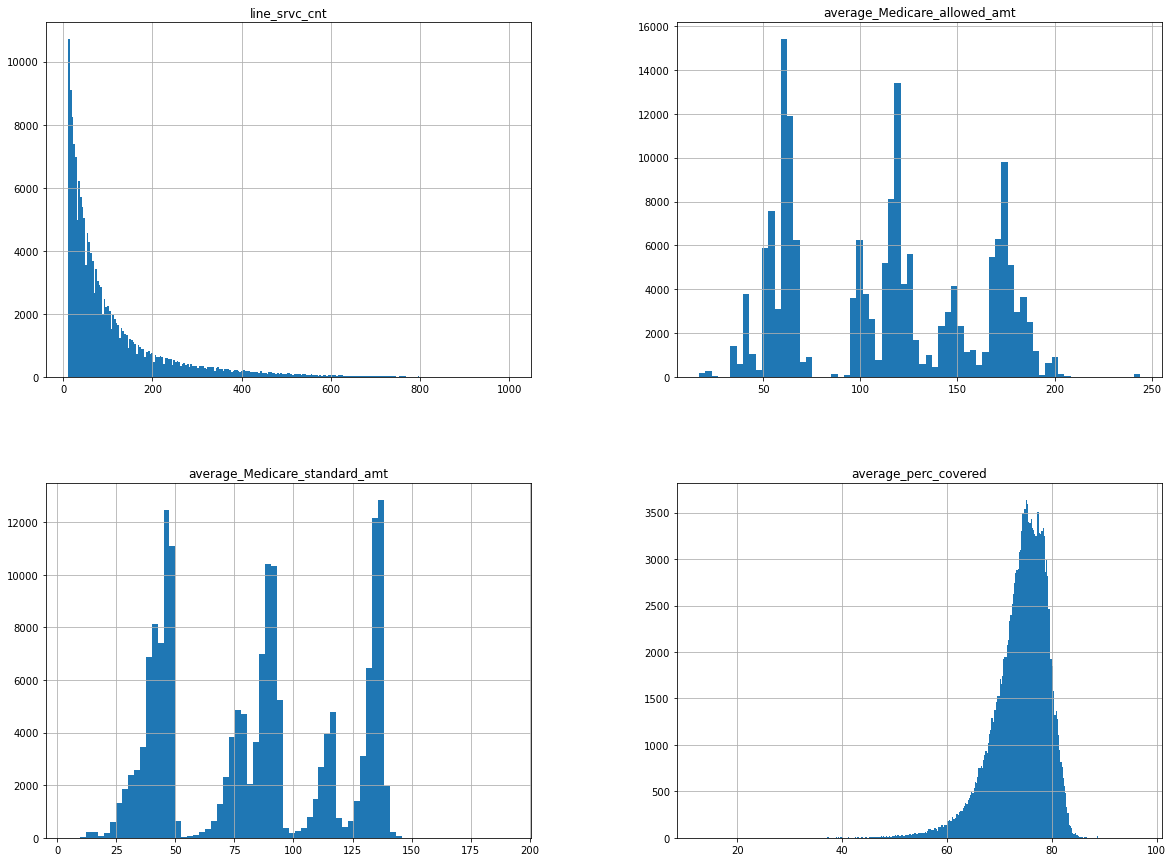

In [176]:
df_ED = df_ED[df_ED['line_srvc_cnt'] <= 1000] # filtering to remove any values above 1000
df_ED = df_ED[df_ED['average_perc_covered'] <= 100] # filtering to remove any values above 100
df_ED.hist(bins = 'auto', figsize = (20,15))
plt.show()

Above represents the frequency histograms of all four of the numeric features. The variable `line_service_cnt` follows an exponential-like distribution, which makes sense as they are whole number “counts” of how many each service has been provided. For the two variables that indicate Medicare expenses, they seem to follow an irregular distribution where certain numbers have a spike. This may be due to “rounding” of expenses to the nearest whole dollar, but it is interesting to note that there are three distinct spikes for both histograms, where each spike is preceded by a similar pattern. This may mean that certain types of services within the ED were overrepresented, where maybe those specified services have distinct costs. I was able to use clustering to gain more insights on how these numeric variables are related to the categorical variables.

Another interesting thing to note was that the percentage of the bill covered by Medicare mostly fall between 60% and 80%, with a slight skew towards 80%.


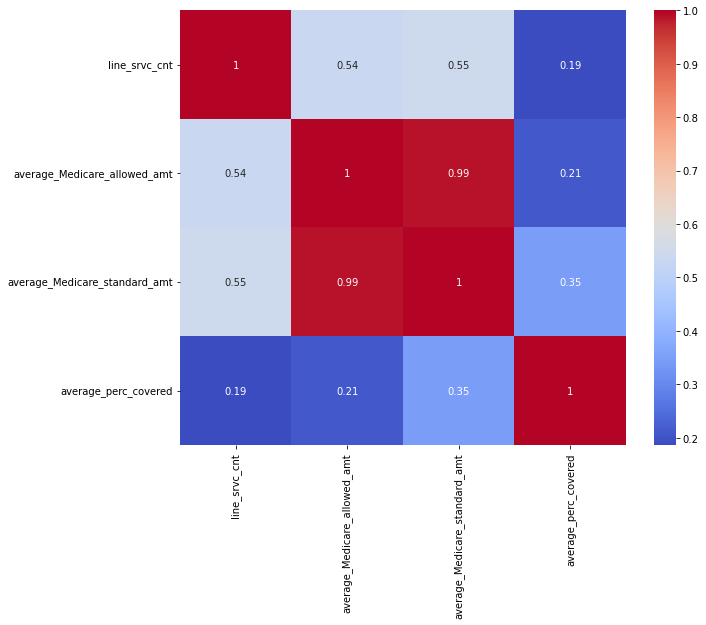

In [18]:
fig,ax = plt.subplots(figsize=(10,8))
sns.heatmap(df_ED.corr(), cmap='coolwarm', annot=True)
plt.show()

A high correlation is observed between total cost `average_Medicare_allowed_amt` and how much medicare is paying for the service `average_Medicare_standard_amt`, which makes sense. These variables are also moderately positively correlated with the number of services (frequently conducted services cost more). Relatively little correlation exists between cost of service and coverage % by Medicare, which is an interesting insight because you would expect service cost to be a major factor in how much of the total cost Medicare is willing to pay. Clustering can reveal other underlying factors.

# III. K-means Clustering

To prepare for clustering, I one-hot encoded categorical variables `provider_type`(6 different possibilities) and `hcpcs_description` (5 different possibilities), and scaling them to prepare for K-means Clustering

In [174]:
df_ED_ohe = pd.get_dummies(df_ED) #One hot encoding
scaler = StandardScaler().fit(df_ED_ohe) #normalizing
df_ED_ohe_norm = scaler.transform(df_ED_ohe)

### SCREE Plot

After one-hot encoding and normalizing the dataset, I ran multiple instances of K-means and obtained the following **Scree Plot** which plots the number of clusters to its respective **SSE**, a measure of variation within each cluster (the sum of the squared differences between each observation and its cluster's mean). SSE is expected to constantly decrease as the number of clusters $k$ increases. I used from $k=2$ to $k=24$.

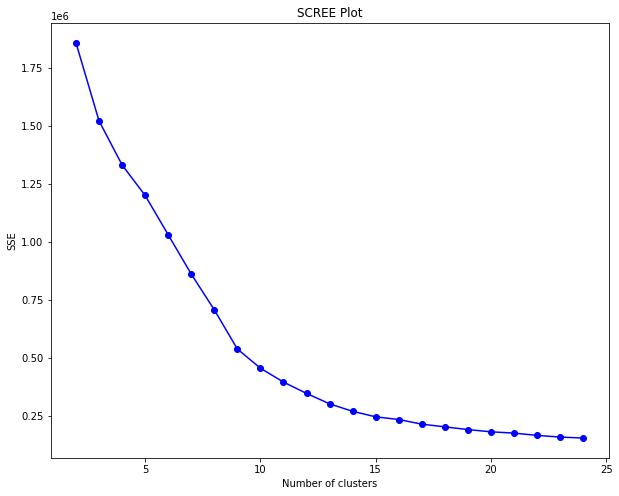

In [177]:
maxClusters = 25
sse = []
for nClusters in range(2,maxClusters):
    kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(df_ED_ohe_norm)
    sse.append(kmeans.inertia_)
plt.figure(figsize=(10,8))
plt.plot(range(2,maxClusters),sse, '-bo')
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title("SCREE Plot")
plt.show()

The plot noticeably has a kink at $k = 9$, and slowly declines after, which suggests that the difference in SSE is relatively marginal after this point. $k = 9$ may be a good number to choose. 

### Silhouette Plot 

In addition to the SCREE Plot, I calculated the **silhouette value** $s$ for each possible number of cluster $k$. The silhouette value is a measure of how similar (or cohesive) an instance is to its own cluster. The higher the $s$, the tighter the clusters are for the given $k$. 
I generated a silhouette score for each k used on the dataset and plotted it from $k=2$ to $k=15$

In [ ]:
maxClusters=16
silh = []
for nClusters in range(2,maxClusters):
    kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(df_ED_ohe_norm)
    silhouette_avg = silhouette_score(df_ED_ohe_norm, kmeans.labels_)
    silh.append(silhouette_avg)

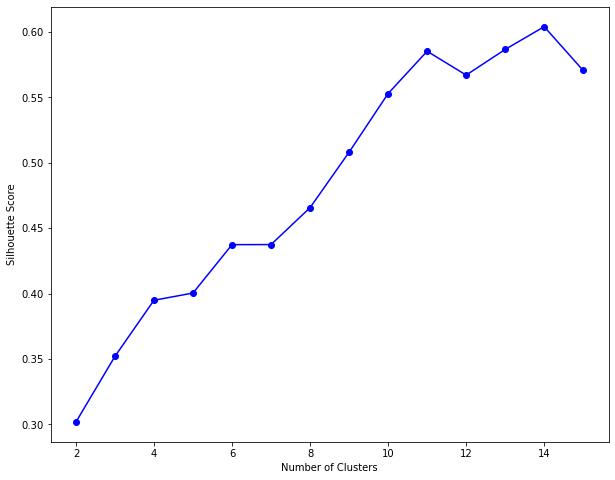

In [121]:
plt.figure(figsize=(10,8))
plt.plot(range(2,maxClusters),silh,'-bo')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Plot")
plt.show()

The silhouette plot suggests a higher range of k, with 14 being the value that generates the greatest silhouette score. Similarly to the SCREE plot, it is suggested to choose a $k$ around where the silhouette score drops off. I will choose $k=11$ because the increase in the silhouette score seems to taper off after this point.

# IV. Clustering Results


After getting the cluster labels for each instance of the dataset, I aggregated (using `df.groupby()`) by cluster to observe the mean values for a cluster for every feature. For the one-hot encoded features, because each columns are either 1 or 0, the mean number will represent the proportion of a certain value in the specified cluster (for example, `provider_type_Emergency Medicine = 0.726` for cluster 5 would mean that 72.6% of lines of services were in Cluster 5). 

In order to get more information about our clusters, I added two more variables, `size` and `Total Average Medicare Cost`. `size` represents the number of instances in each cluster, and `Total Average Medicare Cost` represents average Medicare cost multiplied by the number of lines of services.

In [188]:
kmeans = KMeans(n_clusters=11, random_state=0).fit(df_ED_ohe_norm)
# obtaining and storing clusters for each instance
clusters = pd.DataFrame(kmeans.labels_, columns = ['Cluster'])
#resetting index to aid concatenation
df_ED_final = df_ED_ohe.reset_index().drop(["index"], axis=1)
# appending each instance with its cluster
data = pd.concat([clusters, df_ED_final], axis = 1)
# grouping by cluster and averaging 
meanpercluster = data.groupby('Cluster').mean()

# Adding new variables

# adding counts of instances for each cluster
counts = pd.DataFrame(data.groupby('Cluster').size().reset_index(name='size'))
meanpercluster = counts.merge(meanpercluster, how = "inner", on = "Cluster").set_index("Cluster", drop = True)
# adding total average cost (average paid by Medicare per service times the number of service, per provider)
totalcost = meanpercluster['average_Medicare_standard_amt']*meanpercluster['line_srvc_cnt']
meanpercluster.insert(loc=2, column='Total Average Medicare Cost', value=totalcost)

In [189]:
meanpercluster 

,size,line_srvc_cnt,Total Average Medicare Cost,average_Medicare_allowed_amt,average_Medicare_standard_amt,average_perc_covered,provider_type_Cardiology,provider_type_Emergency Medicine,provider_type_Internal Medicine,provider_type_Nurse Practitioner,provider_type_Physician Assistant,"hcpcs_description_Emergency department visit, low to moderately severe problem","hcpcs_description_Emergency department visit, moderately severe problem","hcpcs_description_Emergency department visit, problem of high severity","hcpcs_description_Emergency department visit, problem with significant threat to life or function","hcpcs_description_Emergency department visit, self limited or minor problem"
Cluster,,,,,,,,,,,,,,,,
0,34406,51.192583,2348.906570,63.280765,45.883729,72.652380,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.999971,0.000000,0.000029,0.0
1,9848,78.280158,8877.454114,149.712491,113.406185,75.865674,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.0
2,38513,246.318905,33027.457855,176.879505,134.084137,75.959456,0.000000,0.999766,0.000000,0.000130,0.000104,0.000000,0.000026,0.000078,0.999896,0.0
3,478,32.077406,3035.775992,129.126198,94.639074,73.532757,1.000000,0.000000,0.000000,0.000000,0.000000,0.037657,0.146444,0.520921,0.294979,0.0
4,38501,103.008831,9140.661845,120.095967,88.736682,74.038855,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.999948,0.000052,0.0
5,6893,25.621790,740.780478,40.301589,28.912128,71.868199,0.000000,0.726244,0.000000,0.099811,0.173945,1.000000,0.000000,0.000000,0.000000,0.0
6,476,21.338235,313.211159,20.469681,14.678400,71.947767,0.002101,0.535714,0.048319,0.151261,0.262605,0.000000,0.000000,0.000000,0.000000,1.0
7,3614,113.863586,9799.363702,114.908249,86.062314,74.493090,0.000000,0.000000,1.000000,0.000000,0.000000,0.055617,0.305202,0.330105,0.309076,0.0
8,17193,62.829349,4646.503452,99.042512,73.954346,74.129338,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.336474,0.358809,0.304717,0.0


I sorted through the above dataset to make each cluster more interpretable.

In [202]:
cluster0 = ['All EM', 'Almost all Moderate']
cluster1 = ['All PA', 'All Life Threatening']
cluster2 = ['Almost All EM', 'Almost All Life Threatening']
cluster3 = ['All Cardiology', 'Varies, Higher End Severity']
cluster4 = ['All EM', 'Almost All High']
cluster5 = ['72.6% EM, NP, PA', 'All Low']
cluster6 = ['Half EM, then Various', 'All Minor']
cluster7 = ['All Internal Medicine', 'Moderate/High/Life Threatening']
cluster8 = ['All Nurse Practitioners', 'Moderate/High/Life Threatening']
cluster9 = ['All PA', 'All Moderate']
cluster10 = ['All PA', 'All high']


summary = pd.DataFrame([cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10], 
             columns = ['Provider Type', 'ED Visit Severity']).rename_axis('Cluster')
summary_num = meanpercluster[['average_Medicare_allowed_amt', 'Total Average Medicare Cost',
                'average_perc_covered', 'line_srvc_cnt', 'size']]
summary_num.columns= ['Average Medicare Cost per Service', 'Average Medicare Total Cost',
                        'Average Coverage %', 'Average Frequency of Service', 'Size of Cluster']
summary = summary.merge(summary_num, on = "Cluster")


Sorting the clusters in descending order of `Average Medicare Cost per Service`

In [205]:
summary.sort_values("Average Medicare Cost per Service", ascending = False)

,Provider Type,ED Visit Severity,Average Medicare Cost per Service,Average Medicare Total Cost,Average Coverage %,Average Frequency of Service,Size of Cluster
Cluster,,,,,,,
2,Almost All EM,Almost All Life Threatening,176.879505,33027.457855,75.959456,246.318905,38513
1,All PA,All Life Threatening,149.712491,8877.454114,75.865674,78.280158,9848
3,All Cardiology,"Varies, Higher End Severity",129.126198,3035.775992,73.532757,32.077406,478
4,All EM,Almost All High,120.095967,9140.661845,74.038855,103.008831,38501
7,All Internal Medicine,Moderate/High/Life Threatening,114.908249,9799.363702,74.493090,113.863586,3614
10,All PA,All high,101.784177,4684.142326,73.471660,62.739298,11143
8,All Nurse Practitioners,Moderate/High/Life Threatening,99.042512,4646.503452,74.129338,62.829349,17193
0,All EM,Almost all Moderate,63.280765,2348.906570,72.652380,51.192583,34406
9,All PA,All Moderate,53.743603,1907.118863,71.814186,49.499240,10528


**Each numeric value represents the average for each observation in the cluster (except Size)**

Notable patterns
- **Cluster 2** 
    - Biggest cluster
    - Highest average cost per service/total cost
    - Highest average coverage rate 
    - Highest freqeuncy
    - Almost entirely composed of instances associated with life threatening visits (Highest severity)
- All of the instances with minor ED visits were grouped in **Cluster 6**, and is entirely composed of minor ED visits. It also has the lowest costs and lowest coverage rate. It is also the smallest cluster. 

- **Cluster 0**, **Cluster 2**, and **Cluster 4** are composed entirely of Emergency Medicine services, with visit severity levels that are almost uniform across the cluster. To define these clusters
        - Cluster 2 - EM/Life threatening severity
        - Cluster 4 - EM/High severity
        - Cluster 0 - EM/Moderate severity
    - **Average cost per service/total cost, coverage rate, frequency of service all increase with increasing severity level of ED Visit**
        - Because all of these clusters are composed of entirely EM instances, this suggests that severity is very important in determining these features. 
    - These clusters are also comparable in sizes, very similar.
    
- We see a similar pattern as above for **Cluster 1**, **Cluster 9**, **Cluster 10**, except instead of EM, these are instances associated with services provided by Physician Assistants. 
        - Cluster 1 - PA/Life threatening severity
        - Cluster 10 - PA/High severity
        - Cluster 9 - PA/Moderate severity
    - They exhibit similar patterns of increasing cost, coverage rate, and frequency with increasing severity. 
    - It's important to note that the numbers are significantly lower than instances associated with EMs. This suggests that services provided by Emergency Medicine is more costly and more frequent. Total bill is more covered by Medicare in greater proportion than compared to Physician Assistant types. 
    
- Often times, instances in clusters will entirely compose of a certain Provider Type, especially if these types are not very represented in the dataset. 
    - This suggests that the clustering algorithm detected that some of these numeric metrics are determined by Provider Type.
    - We can make a rough ranking for Provider Type based on their associated features
        - **Most expensive lines of services: Emergency Medicine > Physician Assistant > Cardiology > Internal Medicine > Nurse Practitioners**
        - **Frequency of service per provider: EM > Internal Medicine> PA > NP > Cardiology**

- **Severity Level** is the greatest determinant of coverage rate, regardless of provider type
    - In the table below, sorted by coverage rate, the severity clearly trends down with decreasing coverage rate. One exception is **Cluster 9**, where with moderate severity, the coverage rate is the lowest. 

In [206]:
summary.sort_values("Average Coverage %", ascending = False)

,Provider Type,ED Visit Severity,Average Medicare Cost per Service,Average Medicare Total Cost,Average Coverage %,Average Frequency of Service,Size of Cluster
Cluster,,,,,,,
2,Almost All EM,Almost All Life Threatening,176.879505,33027.457855,75.959456,246.318905,38513
1,All PA,All Life Threatening,149.712491,8877.454114,75.865674,78.280158,9848
7,All Internal Medicine,Moderate/High/Life Threatening,114.908249,9799.363702,74.493090,113.863586,3614
8,All Nurse Practitioners,Moderate/High/Life Threatening,99.042512,4646.503452,74.129338,62.829349,17193
4,All EM,Almost All High,120.095967,9140.661845,74.038855,103.008831,38501
3,All Cardiology,"Varies, Higher End Severity",129.126198,3035.775992,73.532757,32.077406,478
10,All PA,All high,101.784177,4684.142326,73.471660,62.739298,11143
0,All EM,Almost all Moderate,63.280765,2348.906570,72.652380,51.192583,34406
6,"Half EM, then Various",All Minor,20.469681,313.211159,71.947767,21.338235,476


# V. Conclusion

- In terms of lines of services that are associated with Emergency Department visits, **expenditure and coverage rate depends on the severity level of the visit**.
    - This makes sense as severe procedures are likely to cost more and require more attention.
    - Severity level is the most distinct determinant factor of coverage rate. 
        - This is worth investigating. High cost makes sense as determinant of coverage rate as beneficiaries are likely to demand more coverage as cost of the service becomes very high. However, the results show this is not necessarily the case, as the above table shows that EM/life threatening services are covered at comparable rates as PA services, even though the former is much more expensive and frequently occurring. Investigating the processes in determining coverage rate and comparing with any existing benchmarks may be useful in making future decisions.
        
- Expenditure depends on the type of the provider. 
    - Provider determining expenditure makes sense as certain professions within the medical setting make more money than others (Doctors who practice emergency medicine make more than Nurse Practitioners). 
    
- Frequently occurring instances of services cost the most. 
    - Services associated with EM and that deal with life threatening issues are the most commonly occurring in their respective types, and are also both most expensive. 
    - The fact that frequency and cost per service are highly correlated with each other is something to note. 
    - Identifying in any waste or inefficiencies in insuring EM/Life threatening cases will be beneficial in terms of minimizing total Medicare expenditure.  

Possible future analysis can be done by using previous or future sets of data on the CMS website to compare how some of these patterns have changed over time. This may generate more insights about how the nature of the healthcare industry has shifted over time, over the course of different government officials taking office. 
